Firstly, we calculate the first three eigenstates of Fluxonium qubit

$$H=4 E_{C} \hat{n}^{2}+\frac{1}{2} E_{L} \hat{\varphi}^{2}-E_{J} \cos \left(\hat{\varphi}-2 \pi \frac{\Phi_{\text {ext }}}{\Phi_{0}}\right)$$

In [1]:
import jax
from jax import jit, vmap, grad
from jax import random
import jax.numpy as jnp
from jax import vjp

from jax.experimental import ode, optimizers
from jax.experimental.ode import odeint

from jax.config import config  # Force Jax use float64 as default Float dtype
config.update("jax_enable_x64", True)

key = random.PRNGKey(42)

sx= jnp.array([[0,1],[1,0]],dtype=jnp.float64)

In [2]:
import numpy as np 
from scipy.linalg import eigh 

#we set mu = hbar = 1

#mesh of the finite difference 
xmin = -10; xmax = 10; Nmesh = 2000
xmesh = jnp.linspace(xmin, xmax, Nmesh)

p0 = 0.5
Ej , Ec , El= 8.97, 2.47, 0.520

h = xmesh[1] - xmesh[0]

@jit
def buildH(p,Ec,El,Ej):
    Vx = jnp.array([0.5*El*x**2-Ej*jnp.cos(x-2*jnp.pi*p) for x in xmesh])
    H = jnp.diag(Vx) 
    return H - jnp.eye(Nmesh)*(Ec*8./(h*h))+ (jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h)

energies: [-246756.36783604 -246756.36543145 -246750.31074667]
E = 0.0


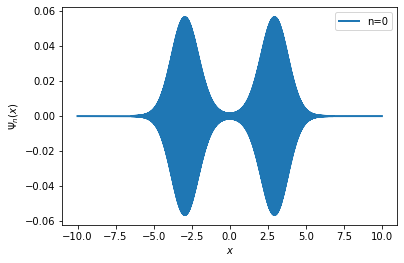

E = 0.0024045901955105364


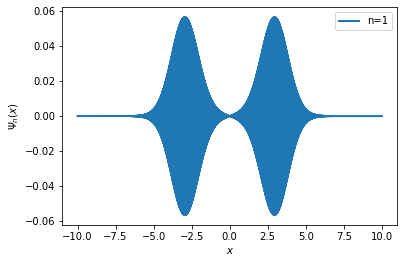

E = 6.057089369453024


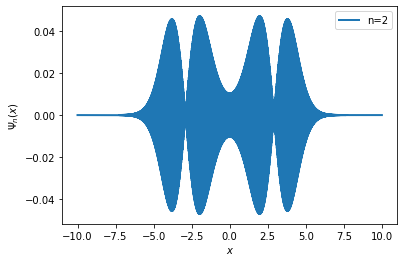

In [3]:
H = buildH(p0,Ec,El,Ej)
w, v = eigh(H)

nlowest = 3
print ('energies:', w[0:nlowest])

E0 = w[0]

import matplotlib.pyplot as plt
#plt.plot(xmesh, [Vpot(x) for x in xmesh], 'k-', lw=2)

for n in range(nlowest):
    print(f"E = {w[n]-w[0]}")
    plt.figure(n)
    plt.plot(xmesh, v[:,n], label='n=%g'%(n), lw=2)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi_{n}(x)$')
    plt.legend()
    plt.show()

One of prominent features of Fluxonium is its large energy gap between computational qubit states and excited states. Due to this feature, we can project the wavefunction and Hamiltonian into the qubit computational subspace.

$$ P = |e\rangle\langle e|+|g\rangle\langle g|$$

And the Hamiltonian would become

$$ P\hat{H} P^T = P \hat{H}_h P^T - E_j[P\cos (\hat{\phi})P^T \cos (2\pi \frac{\phi_{ext}}{\phi_0})+  P\sin(\hat{\phi})P^T \sin (2\pi \frac{\phi_{ext}}{\phi_0})]$$

In this case, to save computational resource, each matrix can be stored precedingly.

In [4]:
P_sub = v[0:2,:]

CosMat = Ej*P_sub@jnp.diag(jnp.array([jnp.cos(x) for x in xmesh]))@P_sub.T
SinMat = Ej*P_sub@jnp.diag(jnp.array([jnp.sin(x) for x in xmesh]))@P_sub.T
H_harm = P_sub@(jnp.eye(Nmesh)*(Ec*8./(h*h))+ (jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h) # Kinetic energy
                 + jnp.diag(jnp.array([0.5*El*x**2 for x in xmesh])))@P_sub.T

In [5]:
@jit
def H_sub(phi):
    return H_harm-(CosMat*jnp.cos(2*jnp.pi*phi)+SinMat*jnp.sin(2*jnp.pi*phi))

Til now we can try optmize control in this sub system, for example $\sigma_x$ gate

In [6]:
@jit
def A(t,p,t1):
    '''
    Control field phi
    '''
    w = jnp.pi/t1
    N1, = jnp.shape(p)
    ft = jnp.array([jnp.sin(w*(i+1)*t) for i in range(N1)])
    return p@ft+p0

@jit
def loss(t1,flat_p,H0,Cosphi,Sinphi,U_T):
    '''
    define the loss function, which is a pure function to speed up
    '''
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix
    
    def H_sub(phi):
        return H0-(Cosphi*jnp.cos(2*jnp.pi*phi)+Sinphi*jnp.sin(2*jnp.pi*phi))

    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
#     print(U_F)
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)

One way of optimize is with L-BFGS

In [7]:
from scipy.optimize import minimize

def GateOptimize_LBFGS(U_F, t1, H0,Cosphi,Sinphi, init_param,):
    '''
    Implementation with LBFGS
    '''
    loss_list = []
    
    loss_and_grad = jit(jax.value_and_grad(loss,(0,1)))
    
    def fun(p,*args):
        t0, p0 = p[0], p[1:]
        f, (gt,gp) = loss_and_grad(t0,p0,H0,Cosphi,Sinphi,U_F)
        gd = np.concatenate([np.array([gt]),gp])
        loss_list.append(f)
        return f, gd
    
    results = minimize(fun,np.concatenate([np.array([t1]),init_param]), method='L-BFGS-B', jac=True, 
                       options={'gtol': 1e-07})
    return loss_list,results.x

With ADAM optimizer as well

In [20]:
def GateOptimize_adam(U_F, t1, init_param,H0,Cosphi,Sinphi, num_step=200, learning_rate=1.0):
    '''
    Get the best possible parameter
    psi_i: initial wave function
    psi_f: final wave function
    init_param: initial parameters
    '''
    opt_init, opt_update, get_params = optimizers.adam(
        learning_rate)  # Use adam optimizer
    loss_list = []
    
    import time
    
    def step_fun(step, opt_state, U_F):
        aug_params = get_params(opt_state)
        t1, flat_params = aug_params
        ta = time.time()
        value, grads = jit(jax.value_and_grad(
            loss, (0, 1)))(t1, flat_params, H0,Cosphi,Sinphi, U_F) # use jax autograd
        tb= time.time()
        print(f'value and grad cost {tb-ta} seconds')
        g_t, g_p = grads
        aug_grad = (g_t,g_p)
        opt_state = opt_update(step, aug_grad, opt_state)
        tc= time.time()
        print(f'value and grad cost {tc-tb} seconds')
        return value, opt_state

    aug_params = (t1,init_param)
    opt_state = opt_init(aug_params)

    # optimize
    for step in range(num_step):
        value, opt_state = step_fun(step, opt_state, U_F)
        loss_list.append(value)
        print('step {0} : loss is {1}'.format(
            step, value), end="\r", flush=True)

    print('final loss = ', value, flush=True)
    return loss_list, get_params(opt_state)


In [21]:
N1 = 10
p = random.normal(key,shape=(N1,)) # Normal initialization
t1 = 1. 

loss_list, res_state = GateOptimize_adam(sx,t1,p,H_harm,CosMat,SinMat)
# f, (gt,gp) = jit(jax.value_and_grad(loss,(0,1)))(t1,p,H_harm,CosMat,SinMat,sx)
# loss_list_LBFGS,res = GateOptimize_LBFGS(sx,t1,H_harm,CosMat,SinMat,p)
# t_f,p_f = res[0],res[1:]

value and grad cost 2.77632212638855 seconds
value and grad cost 40.578497886657715 seconds
value and grad cost 3.176987886428833 seconds
value and grad cost 80.84331321716309 seconds
value and grad cost 2.7745449542999268 seconds


KeyboardInterrupt: 

In [17]:
print(f)

0.36312961326080556


In [ ]:
t_list = jnp.linspace(0.,t1,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,p,t1)

plt.plot(t_list,A_list)
plt.show()